In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
from scipy.special import ndtri

from transport_qmc.targets import BananaNormal
from transport_qmc.tqmc import TransportQMC
from transport_qmc.train import lbfgs
from transport_qmc.utils import sample_uniform

In [20]:
d = 2
target = BananaNormal(d)
model = TransportQMC(d, target, num_composition=2, max_deg=10)

U_val = jnp.array(sample_uniform(1024, d, np.random.default_rng(2024), 'mc'))

reverse_kl = jax.jit(model.reverse_kl)

val_fn = jax.jit(lambda params: reverse_kl(params, U_val))

def run(seed, max_iter):
    rng = np.random.default_rng(seed)
    U_mc64 = jnp.array(sample_uniform(64, d, rng, 'mc'))
    U_mc256 = jnp.array(sample_uniform(256, d, rng, 'mc'))
    U_rqmc64 = jnp.array(sample_uniform(64, d, rng, 'rqmc'))
    params = model.init_params()
    _, loss_mc64 = lbfgs(lambda params: model.reverse_kl(params, U_mc64), params, val_fn, max_iter=max_iter, max_lr=1.)
    _, loss_mc256 = lbfgs(lambda params: model.reverse_kl(params, U_mc256), params, val_fn, max_iter=max_iter, max_lr=1.)
    _, loss_rqmc64 = lbfgs(lambda params: model.reverse_kl(params, U_rqmc64), params, val_fn, max_iter=max_iter, max_lr=1.)
    return {'mc64': loss_mc64, 'mc256': loss_mc256, 'rqmc64': loss_rqmc64}


In [ ]:
df_loss = None
for seed in range(5):
    print("seed:", seed)
    res = run(seed, 100)
    df = pd.DataFrame(res)
    df['iter'] = df.index
    df = df.melt(id_vars='iter', var_name='sampler', value_name='loss')
    df['seed'] = seed
    if df_loss is None:
        df_loss = df
    else:
        df_loss = pd.concat([df_loss, df])
df_loss = df_loss.reset_index()

Text(0.5, 1.0, 'Banana target')

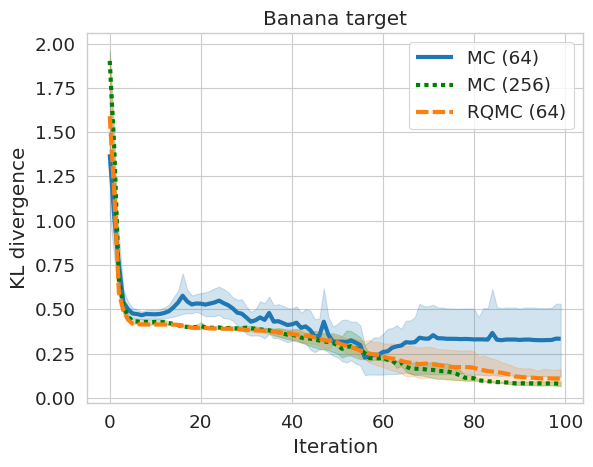

In [22]:
color_list = {'mc64': '#1f77b4', 'mc256': 'green', 'rqmc64': '#ff7f0e'}
dash_list = {'mc64': (1, 0), 'mc256': (1, 1), 'rqmc64': (3, 1)}
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
sns.lineplot(data=df_loss, x='iter', y='loss', hue='sampler', palette=color_list, errorbar=('ci', 95), style='sampler', dashes=dash_list, linewidth=3)

plt.ylabel('KL divergence')
plt.xlabel('Iteration')
handls, labels = plt.gca().get_legend_handles_labels()
plt.legend(handls, ['MC (64)', 'MC (256)', 'RQMC (64)'], title='')
plt.title('Banana target')


In [ ]:
seed = 1
rng = np.random.default_rng(seed)
U_rqmc64 = jnp.array(sample_uniform(64, d, rng, 'rqmc'))
params = model.init_params()
param_100, _ = lbfgs(lambda params: model.reverse_kl(params, U_rqmc64), params, val_fn, max_iter=100, max_lr=1.)
param_150, _ = lbfgs(lambda params: model.reverse_kl(params, U_rqmc64), params, val_fn, max_iter=150, max_lr=1.)

In [10]:
param_100 = param_100[0]
param_150 = param_150[0]

In [11]:
x = np.linspace(-2.6, 2.6, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
Z = np.exp(jax.vmap(target.log_prob)(np.array([X.reshape(-1), Y.reshape(-1)]).T).reshape(X.shape))


U = jnp.array(sample_uniform(2**10, d, np.random.default_rng(2024), 'rqmc'))
samples_0 = ndtri(U)
samples_100 = jax.vmap(model.forward, in_axes=(None, 0))(param_100, U)[0]
samples_150 = jax.vmap(model.forward, in_axes=(None, 0))(param_150, U)[0]

In [12]:
colors = (samples_0[:, 1] - np.min(samples_0[:, 1])) / (np.max(samples_0[:, 1]) - np.min(samples_0[:, 1]))

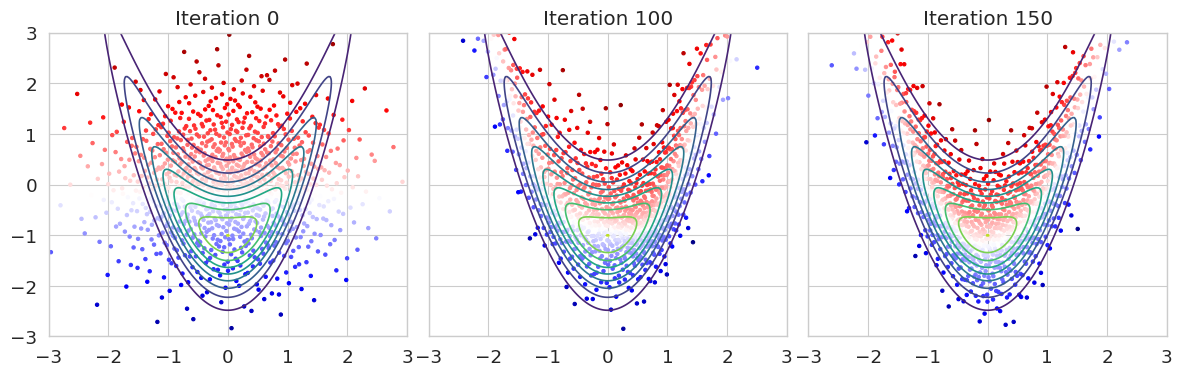

In [13]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
ax[0].contour(X, Y, Z, levels=10, cmap='viridis')
ax[0].scatter(samples_0[:, 0], samples_0[:, 1], marker='.', c=colors, cmap='seismic')
ax[0].set_title('Iteration 0')

ax[1].contour(X, Y, Z, levels=10, cmap='viridis')
ax[1].scatter(samples_100[:, 0], samples_100[:, 1], marker='.', c=colors, cmap='seismic')
ax[1].set_title('Iteration 100')

ax[2].contour(X, Y, Z, levels=10, cmap='viridis')
ax[2].scatter(samples_150[:, 0], samples_150[:, 1], marker='.', c=colors, cmap='seismic')
ax[2].set_title('Iteration 150')
ax[2].set_ylim(-3, 3)
ax[2].set_xlim(-3, 3)
plt.tight_layout()
